In [1]:
%reload_ext autoreload
%autoreload 2
import os
import shapley_value
import pandas as pd
import numpy as np
from getting_data import read_conf
from xai_process import get_smp_shap_data
from s2search_score_pdp import pdp_based_importance

ds_list = [
    'cslg', 'cscv', 'csai', 'csit', 'cscl',
    'cscr', 'csds', 'cssy', 'csni', 'csro',
    'csdc', 'cssi', 'cslo', 'csna', 'cscy',
    'csdm', 'csir', 'csne', 'csse', 'cscc',
    'cshc', 'csgt', 'cssd', 'csdb', 'cscg',
    'cspl', 'csma', 'csce', 'csfl', 'csdl',
    'csmm', 'csgr', 'cspf', 'csar', 'cset', 
    'csoh', 'cssc', 'csms',
]

In [37]:
xai_metrics_arr = []

data_len_of = []

def aggregation(arr):
    # return np.std(arr, ddof=1)
    # return np.mean(np.abs(arr))
    return pdp_based_importance(arr)

def aggregation2(arr):
    # return np.std(arr, ddof=1)
    return np.mean(np.abs(arr))
    # return pdp_based_importance(arr)

for sample_name in ds_list:
    # print(sample_name)
    exp_name = f'exp-{sample_name}'
    exp_path = os.path.join('.', f'pipelining/{exp_name}')
    sv = shapley_value.compute_shapley_value(exp_name, sample_name)
    
    data_len = sv.shape[0]
    
    data_len_of.append(data_len)

    sv_fi = [
        aggregation2(sv[col])
        for col in sv.columns
    ]
    
    ale_fi = []
    for feature_name in ['title', 'abstract', 'venue', 'authors', 'year', 'n_citations']:
        ale_npz_file = os.path.join(exp_path, 'scores', f'{sample_name}_1w_ale_{feature_name}.npz')
        ale_fi.append(aggregation(np.load(ale_npz_file)['ale_result'])) 

    anchor_fi = []
    _, sample_configs, __  = read_conf(exp_path)
    metrics = dict(
        title=[],
        abstract=[],
        venue=[],
        authors=[],
        year=[],
        n_citations=[],
    )
    for sample_key in sample_configs.keys():
        sample_tasks = sample_configs[sample_key]['anchor']['task']
        for task in sample_tasks:
            rg = task['range']
            m_file = os.path.join(exp_path, 'scores', f"{sample_key}_anchor_metrics_{rg[0]}_{rg[1]}.npz")
            if os.path.exists(m_file):
                ld = np.load(m_file)
                title = ld['title']
                abstract = ld['abstract']
                venue = ld['venue']
                authors = ld['authors']
                year = ld['year']
                n_citations = ld['n_citations']
                idx = ld['idx']
                
                metrics['title'].extend(title)
                metrics['abstract'].extend(abstract)
                metrics['venue'].extend(venue)
                metrics['authors'].extend(authors)
                metrics['year'].extend(year)
                metrics['n_citations'].extend(n_citations)
                
    for feature_name in ['title', 'abstract', 'venue', 'authors', 'year', 'n_citations']:
        if len(metrics[feature_name]) < data_len:
            zeros = np.zeros([data_len - len(metrics[feature_name])])
            metrics[feature_name].extend(list(zeros))
        anchor_fi.append(aggregation2(metrics[feature_name]))
    
    shap_fi = []
    shap_sv = get_smp_shap_data(exp_name)[sample_name]['shap_sv']
    # print(sv)
                
    shap_sv = np.flipud(np.rot90(np.array(shap_sv)))
    for feature_sv in shap_sv:
        shap_fi.append(aggregation2(feature_sv))
                
    xai_metrics_arr.append([
        sample_name,
        ale_fi, 
        sv_fi,
        anchor_fi,
        shap_fi
    ])
    # break
    
fis = ['ALE', 'Shapley Value', 'Anchors', 'SHAP']

xai_fi_metrics_pd = pd.DataFrame(columns=['dataset', *fis], data=xai_metrics_arr)

# xai_fi_metrics_pd

Median order
ALE
['abstract(6.399)', 'venue(4.1758)', 'title(4.0454)', 'year(0.618)', 'n_citations(0.399)', 'authors(0.0)']
Shapley Value
['abstract(5.9948)', 'title(1.3668)', 'year(1.0101)', 'venue(0.4841)', 'n_citations(0.1692)', 'authors(0.0983)']
Anchors
['abstract(0.477)', 'title(0.1412)', 'year(0.1329)', 'n_citations(0.0379)', 'venue(0.034)', 'authors(0.0061)']
SHAP
['abstract(5.0344)', 'title(1.0304)', 'year(0.8504)', 'venue(0.3946)', 'n_citations(0.1471)', 'authors(0.0893)']

Average order
ALE
['abstract(6.6419)', 'venue(4.2941)', 'title(4.0793)', 'year(0.6034)', 'authors(0.5368)', 'n_citations(0.3893)']
Shapley Value
['abstract(5.4701)', 'title(1.6359)', 'year(1.0298)', 'venue(0.8989)', 'n_citations(0.171)', 'authors(0.0987)']
Anchors
['abstract(0.4659)', 'year(0.1724)', 'title(0.1592)', 'venue(0.0853)', 'n_citations(0.0461)', 'authors(0.0074)']
SHAP
['abstract(4.5293)', 'title(1.2729)', 'year(0.8781)', 'venue(0.7461)', 'n_citations(0.1473)', 'authors(0.0899)']


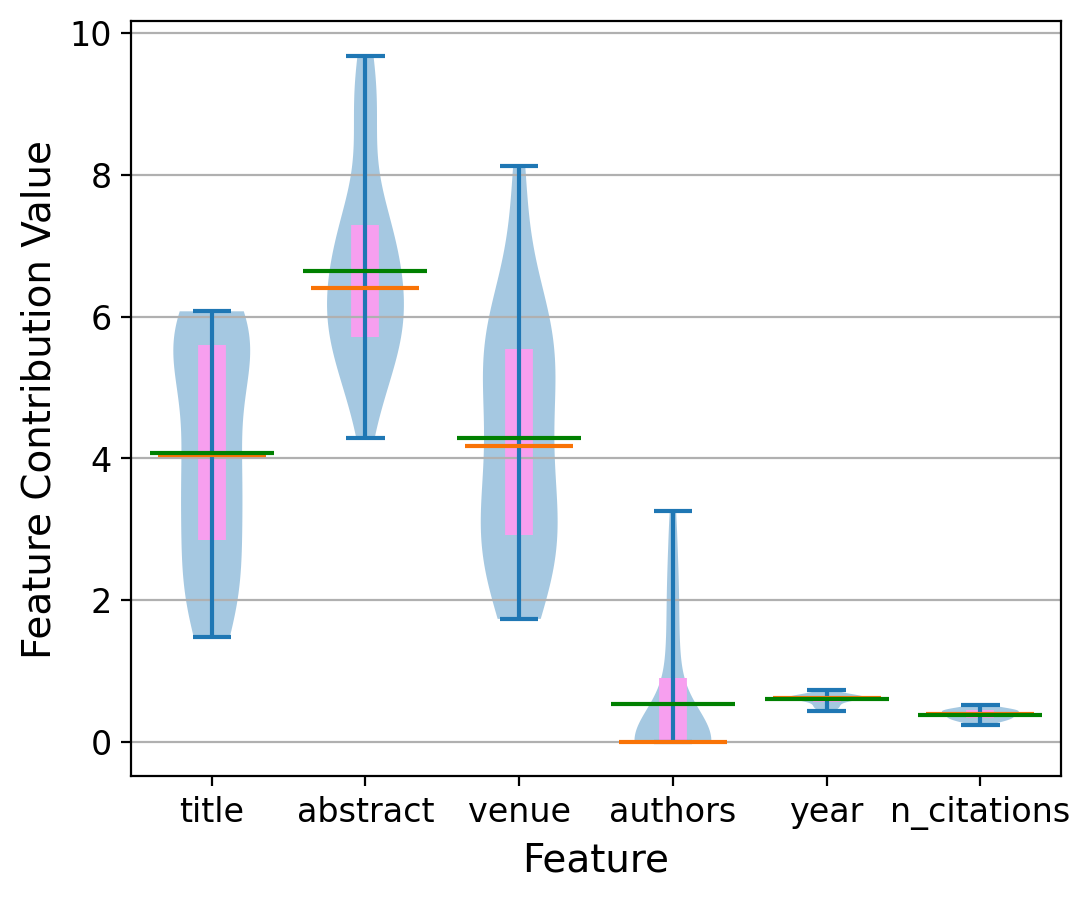

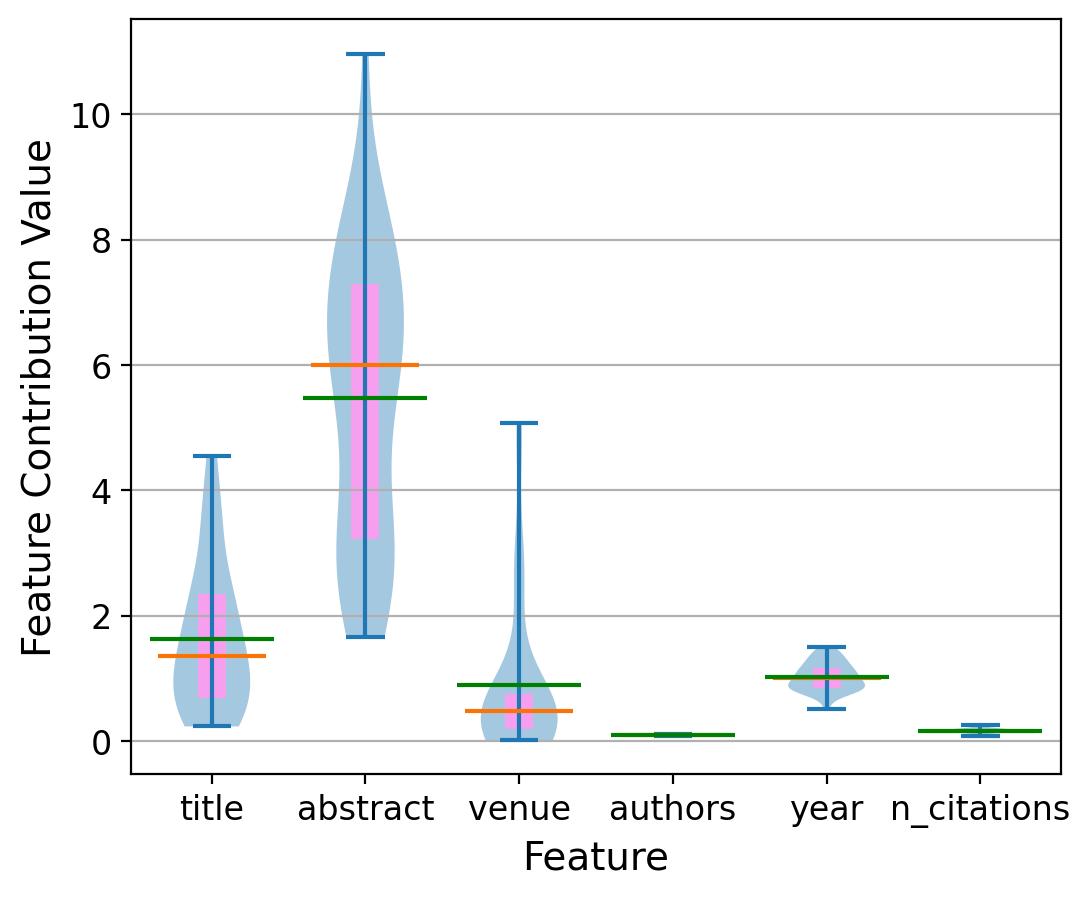

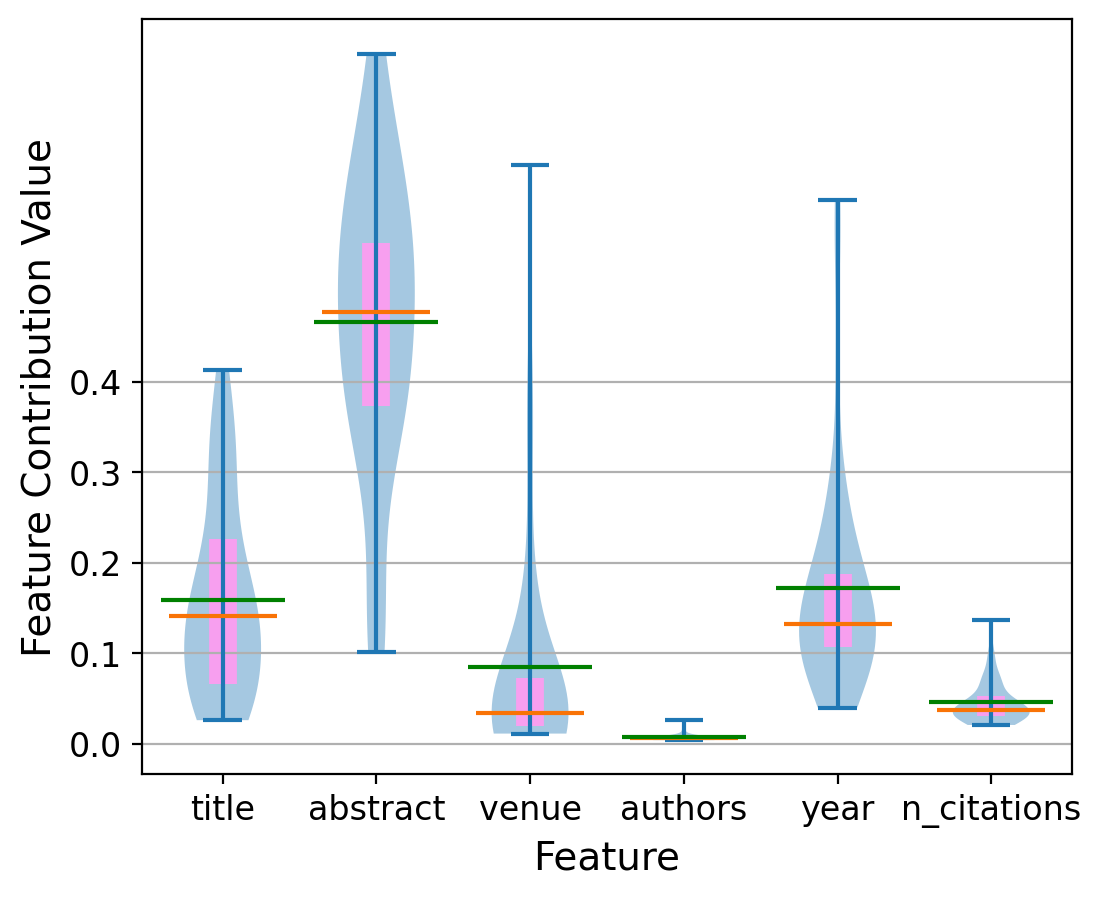

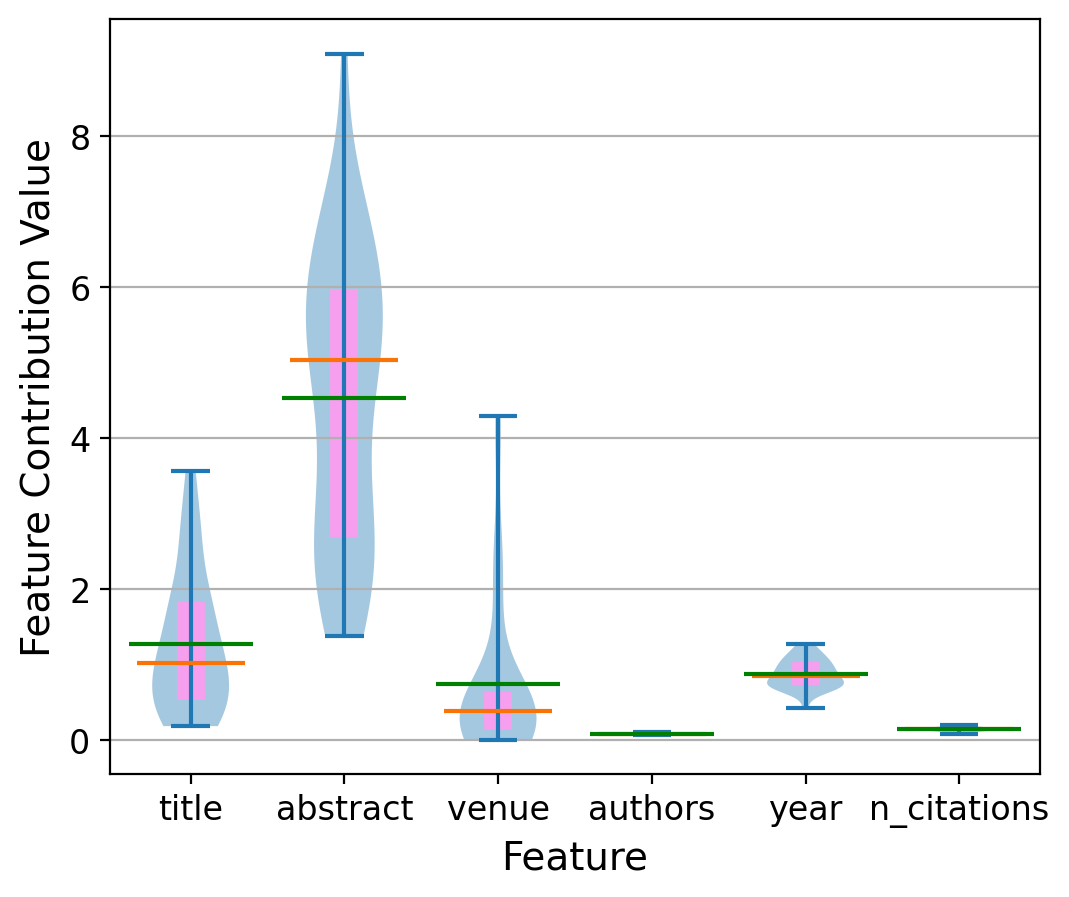

In [38]:
import matplotlib.pyplot as plt

md_map = {}
av_map = {}
mode_map = {}

for fi in fis:
    fi_data = (xai_fi_metrics_pd[fi].to_list())
    mp = {}
    mode_map[fi] = mp
    for one_fi in fi_data:
        order = str(np.flip(np.argsort(one_fi)))
        if mp.get(order) == None:
            mp[order] = 0
        mp[order] += 1
            
    fi_data = np.transpose(fi_data)
    all_data = [list(l) for l in fi_data]
    md_arr = [round(np.median(l), 4) for l in all_data]
    av_arr = [round(np.average(l), 4) for l in all_data]
    md_arr = [
        {
            'feature': ['title', 'abstract', 'venue', 'authors', 'year', 'n_citations'][i],
            'median': md_arr[i],
        }
        for i in range(6)
    ]
    av_arr = [
        {
            'feature': ['title', 'abstract', 'venue', 'authors', 'year', 'n_citations'][i],
            'average': av_arr[i],
        }
        for i in range(6)
    ]
    
    md_map[fi] = sorted(md_arr, key=lambda x:x['median'], reverse=True)
    av_map[fi] = sorted(av_arr, key=lambda x:x['average'], reverse=True)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5), dpi=200)

    # plot box plot
    # ax.boxplot(all_data, 
    #             showfliers=True, 
    #             showmeans=True)
    
    parts = ax.violinplot(all_data, showmeans=False, showmedians=False,
        showextrema=True)
    
    for pc in parts['bodies']:
        # pc.set_facecolor('#029386')
        # pc.set_edgecolor('black')
        pc.set_alpha(0.4)
    
    quartile1, medians, quartile3 = np.percentile(all_data, [25, 50, 75], axis=1)
    # ax.set_title(f'Box Plot of {fi}')
    
    inds = np.arange(1, len(medians) + 1)
    average = np.mean(all_data, axis=1)
    stdd = np.std(all_data, ddof=1, axis=1)
    
    ax.scatter(inds, medians, marker='_', color='#f97306', s=1500, zorder=3, alpha=1)
    ax.scatter(inds, average, marker='_', color='green', s=2000, zorder=3, alpha=1)
    # ax.scatter(inds, stdd, marker='_', color='blue', s=2000, zorder=3, alpha=1)
    ax.vlines(inds, quartile1, quartile3, color='#f79fef', linestyle='-', lw=10, zorder=1)

    plt.yticks(fontsize=12)
    ax.yaxis.grid(True)
    if (fi == 'Anchors'):
        ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
    ax.set_xticks([y + 1 for y in range(len(all_data))],
                    labels=['title', 'abstract', 'venue', 'authors', 'year', 'n_citations'], 
                    fontsize=12, 
                    # rotation=300, weight='560'
                    )
    ax.set_ylabel('Feature Contribution Value', fontsize=14)
    ax.set_xlabel('Feature', fontsize=14)
    
    # ax.set_xlabel('Feature', fontsize=16)
    # ax.set_ylabel(f'Feature Importance', fontsize=16)

# for k in mode_map.keys():
#     print(k)
#     for kk in mode_map[k].keys():
#         print(kk, mode_map[k][kk])

print("Median order")
for k in md_map.keys():
    print(k)
    print([f"{v['feature']}({v['median']})" for v in md_map[k]])
    
print()
print("Average order")
for k in av_map.keys():
    print(k)
    print([f"{v['feature']}({v['average']})" for v in av_map[k]])

In [36]:
from datetime import datetime
from xai_process import get_smp_shap_paper_count_from_log, get_smp_shap_time_from_log
pd.set_option('display.expand_frame_repr', False)

log_metrics_arr = []

for sample_name in ds_list:
    exp_name = f'exp-{sample_name}'
    exp_path = os.path.join('.', f'pipelining/{exp_name}')
    
    log_path = os.path.join(exp_path, 'log')
    
    log_files_name = os.listdir(log_path)
    
    # get anchor time
    anchor_log_files = [lf for lf in log_files_name if f'{sample_name}_anchor' in lf]
    
    anchor_time_sec = 0.0
    for anchor_log_file in anchor_log_files:
        with open(os.path.join(log_path, anchor_log_file))as f:
            lines = [l.strip() for l in f.readlines() if l.strip() != '']
            anchor_time_sec += float(lines[-1].strip().split('witin ')[1])
    
    # get anchor paper count
    anchor_calls_log_files = [lf for lf in log_files_name if 'ranker_calls_anchor' in lf]

    anchor_paper_count = 0
    for anchor_calls_file in anchor_calls_log_files:
        with open(os.path.join(log_path, anchor_calls_file))as f:
            lines = [l.strip() for l in f.readlines() if l.strip() != '']
            for i in range(len(lines)):
                if i > 0:
                    pre_line = lines[i - 1].strip()
                    curr_line = lines[i].strip()
                    if f'{exp_name} {sample_name}' in pre_line and '=== end' in curr_line:
                        anchor_paper_count += int(curr_line.replace('=', '').replace('end', '').replace(' ', ''))
    
    
    # get shap time
    shap_time_sec = get_smp_shap_time_from_log(exp_name, [sample_name])[sample_name]
    # get shap paper count
    shap_paper_count = get_smp_shap_paper_count_from_log(exp_name, [sample_name])[sample_name]

    
    # get masking paper count and time
    masking_calls_log_files = [lf for lf in log_files_name if 'ranker_calls_masking' in lf]
    
    masking_paper_count = 0
    masking_time_sec = 0
    for masking_calls_file in masking_calls_log_files[-1:]:
        with open(os.path.join(log_path, masking_calls_file))as f:
            lines = [l.strip() for l in f.readlines() if l.strip() != '']
            start_line = None
            end_line = None
            for i in range(len(lines)):
                curr_line = lines[i].strip()
                if i > 0:
                    pre_line = lines[i - 1].strip()
                    if f'{exp_name}_{sample_name}' in pre_line and '=== end' in curr_line:
                        masking_paper_count += int(curr_line.replace('=', '').replace('end', '').replace(' ', ''))
                if f'{exp_name}_{sample_name}' in curr_line:
                    if start_line == None:
                        start_line = curr_line
                    end_line = curr_line
            
            # print(log_path, masking_calls_file)
            start_time = datetime.strptime(start_line[1:start_line.index(']')], '%m/%d/%Y, %H:%M:%S')
            end_time = datetime.strptime(end_line[1:end_line.index(']')], '%m/%d/%Y, %H:%M:%S')
            
            masking_time_sec = (end_time - start_time).total_seconds()
            
    # get ale paper count and time
    ale_calls_log_files = [lf for lf in log_files_name if 'ranker_calls_ale' in lf]
    
    ale_paper_count = 0
    ale_time_sec = 0
    for ale_calls_file in ale_calls_log_files:
        with open(os.path.join(log_path, ale_calls_file))as f:
            lines = [l.strip() for l in f.readlines() if l.strip() != '']
            start_line = None
            end_line = None
            for i in range(len(lines)):
                curr_line = lines[i].strip()
                if i > 0:
                    pre_line = lines[i - 1].strip()
                    if f'{exp_name}_{sample_name}' in pre_line and '=== end' in curr_line:
                        ale_paper_count += int(curr_line.replace('=', '').replace('end', '').replace(' ', ''))
                if f'{exp_name}_{sample_name}' in curr_line:
                    if start_line == None:
                        start_line = curr_line
                    end_line = curr_line
            
            start_time = datetime.strptime(start_line[1:start_line.index(']')], '%m/%d/%Y, %H:%M:%S')
            end_time = datetime.strptime(end_line[1:end_line.index(']')], '%m/%d/%Y, %H:%M:%S')
            
            ale_time_sec = (end_time - start_time).total_seconds()
    
    log_metrics_arr.append([
        sample_name,
        ale_paper_count, round(ale_time_sec),
        masking_paper_count, round(masking_time_sec),
        shap_paper_count, round(shap_time_sec),
        anchor_paper_count, round(anchor_time_sec),
    ])
    # break

ms = ['ale paper', 'ale time', 'sv paper', 'sv time', 'shap paper', 'shap time','anchor paper', 'anchor time',]

log_metrics_pd = pd.DataFrame(columns=['dataset', *ms], data=log_metrics_arr, index=range(1, len(ds_list) + 1))

log_metrics_pd
# print(log_metrics_pd[['dataset', *[s for s in ms if 'paper' in s]]])

,dataset,ale paper,ale time,sv paper,sv time,shap paper,shap time,anchor paper,anchor time
1,cslg,1487008,972,5948032,2849,6226847,2858,134091249,132012
2,cscv,1032496,712,4129984,2052,4323578,2074,119488218,119303
3,csai,629504,406,2518016,1146,2636049,1197,62694316,53953
4,csit,574976,423,2299904,1139,2407713,1176,70142017,65025
5,cscl,492000,313,1968000,772,2060251,920,47660783,42776
6,cscr,309984,191,1239936,456,1298059,549,35199241,29013
7,csds,304272,193,1217088,429,1274140,545,35123110,30047
8,cssy,284992,189,1139968,607,1193405,584,38348909,37647
9,csni,262752,182,1051008,467,1100275,506,31073850,28116
10,csro,257408,156,1029632,366,1077897,462,30963870,25490


o1 r2_score: 0.9964232838
o2 r2_score: 0.9965276705
ALE o1 Curve: y = 0.01066 * x + -1.11305
ALE o2 Curve: y = 0.01097 * x + -0.0000000039 * x^2 + -3.50044
o1 r2_score: 0.9900497356
o2 r2_score: 0.9919472777
Shapley Value o1 Curve: y = 0.03074 * x + -34.68480
Shapley Value o2 Curve: y = 0.02692 * x + 0.0000000477 * x^2 + -5.24278
o1 r2_score: 0.9723705629
o2 r2_score: 0.976449988
Anchor o1 Curve: y = 1.55592 * x + 178.68703
Anchor o2 Curve: y = 1.84156 * x + -0.0000035743 * x^2 + -2026.23158
o1 r2_score: 0.9981085558
o2 r2_score: 0.9981274991
SHAP o1 Curve: y = 0.03131 * x + -13.94655
SHAP o2 Curve: y = 0.03169 * x + -0.0000000048 * x^2 + -16.93067


(-200.0, 4000.0)

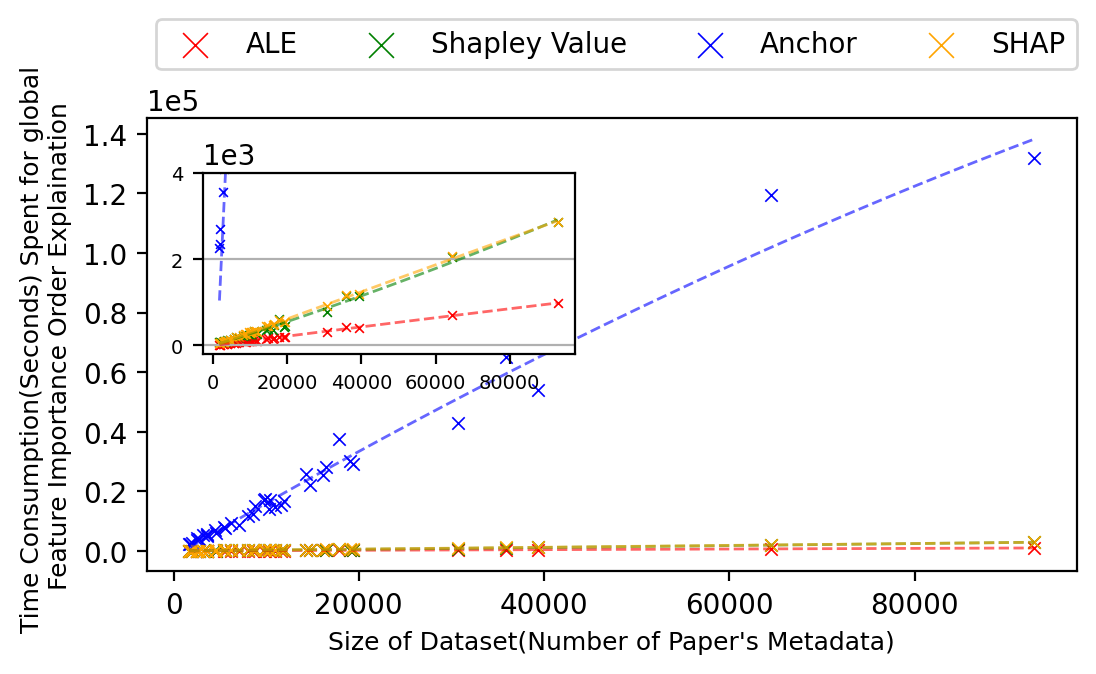

In [28]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def objective_1(x, a, c):
	return a * x + c

def objective_2(x, a, b, c):
	return a * x + b * x**2 + c

x = np.flip(data_len_of)

task = [
	{
		'x': x,
		'y': np.flip(log_metrics_pd['ale time']),
		'label': 'ALE',
		'c': 'red'
	},
 	{
		'x': x,
		'y': np.flip(log_metrics_pd['masking time']),
		'label': 'Shapley Value',
		'c': 'green'
	},
  	{
		'x': x,
		'y': np.flip(log_metrics_pd['anchor time']),
		'label': 'Anchor',
		'c': 'blue'
	},
   	{
		'x': x,
		'y': np.flip(log_metrics_pd['shap time']),
		'label': 'SHAP',
		'c': 'orange'
	},
]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3), dpi=200)
# plt.yscale("log")
# ax.set_xscale("log")
# plt.grid(visible=True, axis='y')

for t in task:    
	ax.scatter(t['x'], t['y'], c=t['c'], s=20, label=t['label'], marker='x', linewidths=0.6)
	x_line = np.arange(min(x), max(x), 1)
 
	popt_1, _1 = curve_fit(objective_1, x, t['y'])
	y_line_1 = objective_1(x_line, *popt_1)
 
	popt_2, _2 = curve_fit(objective_2, x, t['y'])
	y_line_2 = objective_2(x_line, *popt_2)

	r_square_1 = r2_score(t['y'], [objective_1(x_value, *popt_1) for x_value in x])
	r_square_2 = r2_score(t['y'], [objective_2(x_value, *popt_2) for x_value in x])
 
	print(f'o1 r2_score: {round(r_square_1, 10)}')
	print(f'o2 r2_score: {round(r_square_2, 10)}')
 
	if (r_square_1 > r_square_2):
		ax.plot(x_line, y_line_1, '--', color=t['c'], lw=1, alpha=0.6)
	else:
		ax.plot(x_line, y_line_2, '--', color=t['c'], lw=1, alpha=0.6)
     
	print('%s o1 Curve: y = %.5f * x + %.5f' % (t['label'], *popt_1))
	print('%s o2 Curve: y = %.5f * x + %.10f * x^2 + %.5f' % (t['label'], *popt_2))

 
ax.legend(bbox_to_anchor=(1.015,1.25), loc="upper right", ncol=4, markerscale=2)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel('Time Consumption(Seconds) Spent for global \nFeature Importance Order Explaination', fontsize=9)
ax.set_xlabel('Size of Dataset(Number of Paper\'s Metadata)', fontsize=9)
# ax.set_xticks([])
# ax.set_ylim([-200, 20000])
# ax.set_xlim([-200, 20000])

axins = ax.inset_axes([0.06, 0.48, 0.4, 0.4])
# axins.set_xscale("log")
# axins.set_xticks([])
axins.tick_params(axis='y', labelsize=7)
axins.tick_params(axis='x', labelsize=7)
axins.grid(visible=True, axis='y')
for t in task:   
	axins.scatter(t['x'], t['y'], c=t['c'], s=10, label=t['label'], marker='x', linewidths=0.6)
	popt, _ = curve_fit(objective_2, x, t['y'])
	x_line = np.arange(min(x), max(x), 1)
	y_line = objective_2(x_line, *popt)
	axins.plot(x_line, y_line, '--', color=t['c'], lw=1, alpha=0.6)
 
axins.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axins.set_ylim([-200, 4000])

o1 r2_score: 1.0
o2 r2_score: 1.0
ALE o1 Curve: y = 16.00000 * x + -0.00000000000267941225
ALE o2 Curve: y = 16.00000 * x + 0.00000000000112414776 * x^2 + 0.00114
o1 r2_score: 1.0
o2 r2_score: 1.0
Shapley Value o1 Curve: y = 64.00000 * x + 0.00000000016679879700
Shapley Value o2 Curve: y = 64.00000 * x + -0.00000000000114184082 * x^2 + -0.00059
o1 r2_score: 0.9752124985
o2 r2_score: 0.9857914584
Anchor o1 Curve: y = 1584.89098 * x + 2182419.33623487222939729691
Anchor o2 Curve: y = 2052.75169 * x + -0.00585458687205774909 * x^2 + -1429127.14416
o1 r2_score: 0.9991665214
o2 r2_score: 0.9991787156
SHAP o1 Curve: y = 66.80325 * x + 8508.14506920444182469510
SHAP o2 Curve: y = 66.14179 * x + 0.00000827714977245650 * x^2 + 13614.10864


Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated


(-700000.0, 7000000.0)

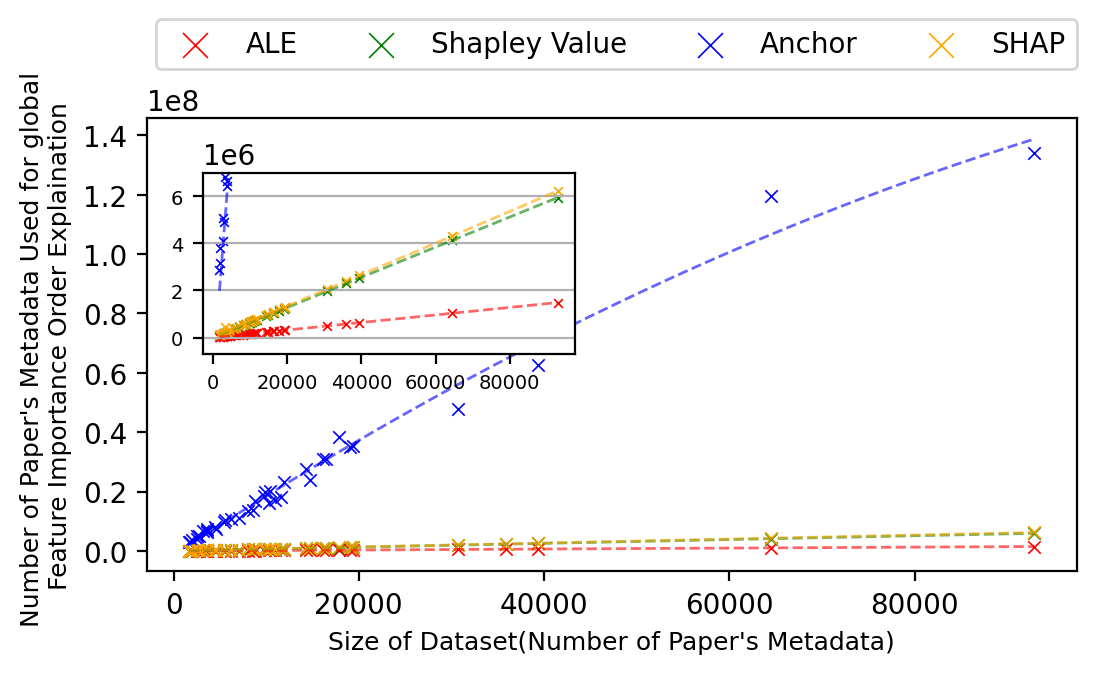

In [29]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3), dpi=200)
# plt.yscale("log")
# plt.xscale("log")
# # plt.grid(visible=True, axis='y')
# ax.plot(np.flip(data_len_of), np.flip(log_metrics_pd['ale paper']), c='red', lw=1, label='ALE')
# ax.plot(np.flip(data_len_of), np.flip(log_metrics_pd['masking paper']), c='green', lw=1, label='Shapley Value')
# ax.plot(np.flip(data_len_of), np.flip(log_metrics_pd['anchor paper']), c='blue', lw=1, label='Anchor')
# ax.plot(np.flip(data_len_of), np.flip(log_metrics_pd['shap paper']), c='cyan', lw=1, label='SHAP')
# ax.legend(bbox_to_anchor=(1.015,1.25), loc="upper right", ncol=4)
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax.set_ylabel('Number of Paper\'s Metadata Used for global \nFeature Importance Order Explaination')
# ax.set_xlabel('Size of Dataset(Number of Paper\'s Metadata)')
# # ax.set_xticks([])


# axins = ax.inset_axes([0.07, 0.3, 0.45, 0.60])
# axins.set_xticks([])
# axins.grid(visible=True, axis='y')
# axins.plot(np.flip(data_len_of), np.flip(log_metrics_pd['ale paper']), c='red', lw=1, label='ALE')
# axins.plot(np.flip(data_len_of), np.flip(log_metrics_pd['masking paper']), c='green', lw=1, label='Shapley Value')
# axins.plot(np.flip(data_len_of), np.flip(log_metrics_pd['anchor paper']), c='blue', lw=1, label='Anchor')
# axins.plot(np.flip(data_len_of), np.flip(log_metrics_pd['shap paper']), c='cyan', lw=1, label='SHAP')
# axins.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# axins.set_ylim([-700000, 7000000])

def objective_1(x, a, c):
	return a * x + c

def objective_2(x, a, b, c):
	return a * x + b * x**2 + c

x = np.flip(data_len_of)

task = [
	{
		'x': x,
		'y': np.flip(log_metrics_pd['ale paper']),
		'label': 'ALE',
		'c': 'red'
	},
 	{
		'x': x,
		'y': np.flip(log_metrics_pd['masking paper']),
		'label': 'Shapley Value',
		'c': 'green'
	},
  	{
		'x': x,
		'y': np.flip(log_metrics_pd['anchor paper']),
		'label': 'Anchor',
		'c': 'blue'
	},
   	{
		'x': x,
		'y': np.flip(log_metrics_pd['shap paper']),
		'label': 'SHAP',
		'c': 'orange'
	},
]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3), dpi=200)
# plt.yscale("log")
# ax.set_xscale("log")
# plt.grid(visible=True, axis='y')

for t in task:    
	ax.scatter(t['x'], t['y'], c=t['c'], s=20, label=t['label'], marker='x', linewidths=0.6)
	x_line = np.arange(min(x), max(x), 1)
 
	popt_1, _1 = curve_fit(objective_1, x, t['y'])
	y_line_1 = objective_1(x_line, *popt_1)
 
	popt_2, _2 = curve_fit(objective_2, x, t['y'])
	y_line_2 = objective_2(x_line, *popt_2)

	r_square_1 = r2_score(t['y'], [objective_1(x_value, *popt_1) for x_value in x])
	r_square_2 = r2_score(t['y'], [objective_2(x_value, *popt_2) for x_value in x])
 
	print(f'o1 r2_score: {round(r_square_1, 10)}')
	print(f'o2 r2_score: {round(r_square_2, 10)}')
 
	if (r_square_1 > r_square_2):
		ax.plot(x_line, y_line_1, '--', color=t['c'], lw=1, alpha=0.6)
	else:
		ax.plot(x_line, y_line_2, '--', color=t['c'], lw=1, alpha=0.6)
     
	print('%s o1 Curve: y = %.5f * x + %.20f' % (t['label'], *popt_1))
	print('%s o2 Curve: y = %.5f * x + %.20f * x^2 + %.5f' % (t['label'], *popt_2))

 
ax.legend(bbox_to_anchor=(1.015,1.25), loc="upper right", ncol=4, markerscale=2)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel('Number of Paper\'s Metadata Used for global \nFeature Importance Order Explaination', fontsize=9)
ax.set_xlabel('Size of Dataset(Number of Paper\'s Metadata)', fontsize=9)

axins = ax.inset_axes([0.06, 0.48, 0.4, 0.4])
# axins.set_xscale("log")

axins.tick_params(axis='y', labelsize=7)
axins.tick_params(axis='x', labelsize=7)
axins.grid(visible=True, axis='y')
for t in task:   
	axins.scatter(t['x'], t['y'], c=t['c'], s=10, label=t['label'], marker='x', linewidths=0.6)
	popt, _ = curve_fit(objective_2, x, t['y'])
	x_line = np.arange(min(x), max(x), 1)
	y_line = objective_2(x_line, *popt)
	axins.plot(x_line, y_line, '--', color=t['c'], lw=1, alpha=0.6)
 
axins.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axins.set_ylim([-700000, 7000000])

In [7]:
from xai_process import get_smp_shap_time_from_log
get_smp_shap_time_from_log('exp-inhouse')

{'cslg': 236387.48929899998,
 'cscv': 130763.24924500001,
 'csai': 54793.774435,
 'csit': 51452.47601699999,
 'cscl': 37892.727568,
 'cscr': 19984.42053,
 'csds': 18843.671666,
 'cssy': 19173.870015999997,
 'csni': 15396.538973999997,
 'csro': 14665.266641999999,
 'csdc': 13022.130112,
 'cssi': 14577.982808999997,
 'cslo': 8876.767346,
 'csna': 9503.029594,
 'cscy': 8461.312933000001,
 'csdm': 7816.470743000001,
 'csir': 8756.865684,
 'csne': 8522.915251999999,
 'csse': 8839.318549,
 'cscc': 7150.578614999999,
 'cshc': 7306.313557,
 'csgt': 6592.210872999999,
 'cssd': 4964.734757000001,
 'csdb': 4036.267797,
 'cspl': 3797.1071709999997,
 'cscg': 3572.320696,
 'csce': 3255.137623,
 'csma': 3276.490917,
 'csmm': 2146.82674,
 'csdl': 2461.473261,
 'csgr': 2057.0846109999998,
 'csfl': 2632.9903699999995,
 'cspf': 1652.9079980000001,
 'csar': 1770.768388,
 'cset': 1584.3185059999998,
 'csoh': 885.6887820000001,
 'csms': 990.759211,
 'cssc': 958.773431,
 'csos': 373.786345,
 'csgl': 78.74233

In [8]:
param_arr = []

for sample_name in ds_list:
    exp_name = f'exp-{sample_name}'
    exp_path = os.path.join('.', f'pipelining/{exp_name}')

    _, sample_configs, __  = read_conf(exp_path)
    
    ale_quantiles = sample_configs[sample_name]['ale_1w'][0]['quantiles']
    
    param_arr.append([
        sample_name,
        [ale_quantiles[feature] for feature in ['title', 'abstract', 'venue', 'authors', 'year', 'n_citations']]
    ])

l1 = ['ale quantiles']

param_df = pd.DataFrame(columns=['dataset', *l1], data=param_arr)

param_df

,dataset,ale quantiles
0,cslg,"[2, 2, 2, 2, 2, 2]"
1,cscv,"[2, 2, 2, 2, 2, 2]"
2,csai,"[2, 2, 2, 2, 2, 2]"
3,csit,"[2, 2, 2, 2, 2, 2]"
4,cscl,"[2, 2, 2, 2, 2, 2]"
5,cscr,"[5, 5, 5, 5, 5, 5]"
6,csds,"[5, 5, 5, 5, 5, 5]"
7,cssy,"[5, 5, 5, 5, 5, 5]"
8,csni,"[5, 5, 5, 5, 5, 5]"
9,csro,"[5, 5, 5, 5, 5, 5]"
